## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

### Code

In [1]:
import glob
import numpy as np
import scipy as sp
import scipy.io
import matplotlib.pyplot as plt
import scipy.signal
%matplotlib inline

fs = 125
window_length_s = 8
window_shift_s = 2
window_length = window_length_s * fs
window_shift = window_shift_s * fs

minfreq = 40/60.0
maxfreq = 240/60.0

def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls

def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]

def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estim0tes = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))

def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)

def RunPulseRateAlgorithm(data_fl, ref_fl):
    # Load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    
    # load ref ground truth
    ground_truth = sp.io.loadmat(ref_fl)['BPM0']
    
    # apply bandpass filter to signals
    ppg = Bandpass_filter(ppg)
    accx = Bandpass_filter(accx)
    accy = Bandpass_filter(accy)
    accz = Bandpass_filter(accz)
    
    # Compute pulse rate estimates and estimation confidence.
    est_bpm, confidence = estimate_bpm(ppg, accx, accy, accz)

    est_bpm = np.array(est_bpm)
    
    errors = np.abs(np.diag(np.subtract(ground_truth, est_bpm)))
       
    # Return per-estimate mean absolute error and confidence as a 2-tuple of numpy arrays.
    
    return errors, confidence

def Bandpass_filter(signal):
    """
    filter the signal of bpm between 40 bpm and 240 bpm
    Args:
        signal: acceleromter and ppg signal
    
    Returns:
        bandpass filtered signal
    """
    fs = 125
    pass_range = (40/60.0, 240/60.0)
    b, a = scipy.signal.butter(3, pass_range, btype='bandpass', fs=fs)
    return scipy.signal.filtfilt(b, a, signal)

def Fourier_Transform(signal):
    freqs = np.fft.rfftfreq(len(signal), 1/fs)
    fft = np.fft.rfft(signal)
    return freqs, np.abs(fft)

def estimate_bpm(ppg, accx, accy, accz):
    est_bpm = []
    confidence = []
    
    for i in range(0, len(ppg) - window_length, window_shift):
        ppg_seg = ppg[i: i + window_length]
        accx_seg = accx[i: i + window_length]
        accy_seg = accy[i: i + window_length]
        accz_seg = accz[i: i + window_length]
        
        ppg_freqs, ppg_fft = Fourier_Transform(ppg_seg)
        accx_freqs, accx_fft = Fourier_Transform(accx_seg)
        accy_freqs, accy_fft = Fourier_Transform(accy_seg)
        accz_freqs, accz_fft = Fourier_Transform(accz_seg)
        
        ppg_fft[ppg_freqs <= minfreq] = 0.0
        ppg_fft[ppg_freqs >= maxfreq] = 0.0

        accx_fft[accx_freqs <= minfreq] = 0.0
        accx_fft[accx_freqs >= maxfreq] = 0.0
        
        accy_fft[accy_freqs <= minfreq] = 0.0
        accy_fft[accy_freqs >= maxfreq] = 0.0
        
        accz_fft[accz_freqs <= minfreq] = 0.0
        accz_fft[accz_freqs >= maxfreq] = 0.0
        
        ppg_sorted = ppg_freqs[np.argsort(ppg_fft, axis=0)]
        accx_sorted = accx_freqs[np.argsort(accx_fft, axis=0)]
        accy_sorted = accy_freqs[np.argsort(accy_fft, axis=0)]
        accz_sorted = accz_freqs[np.argsort(accz_fft, axis=0)]
        
        for j in range(1, 100):
            if np.abs(ppg_sorted[-j] - accx_sorted[-j]) == 0 or np.abs(ppg_sorted[-j] - accy_sorted[-j]) == 0 or np.abs(ppg_sorted[-j] - accz_sorted[-j]) == 0:
                continue
            else: est_f = ppg_sorted[-j] 
            break
                      
        conf = calc_confidence(ppg_fft, ppg_freqs, est_f)
        
        est_bpm.append(est_f * 60)
        confidence.append(conf)
    return est_bpm, confidence

def calc_confidence(fft, freqs, est_fs):
    fs_win = 30  / 60.0
    fs_win_e = (freqs >= est_fs - fs_win) & (freqs <= est_fs + fs_win)
    return np.sum(fft[fs_win_e])/np.sum(fft)

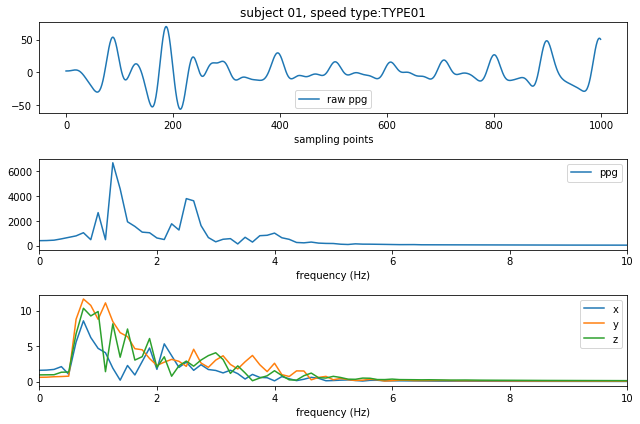

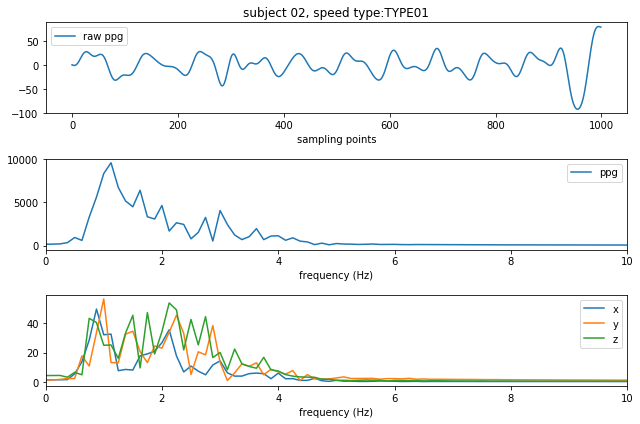

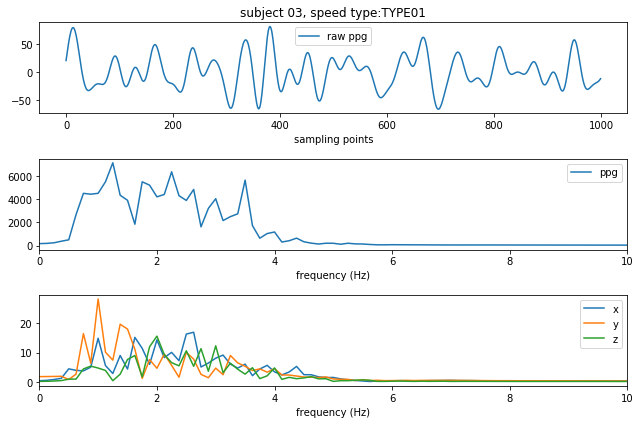

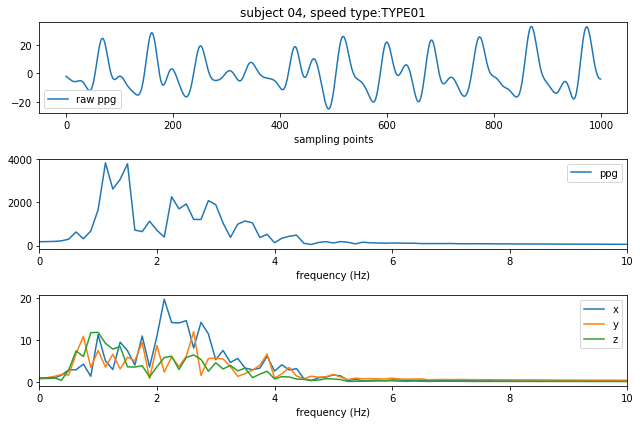

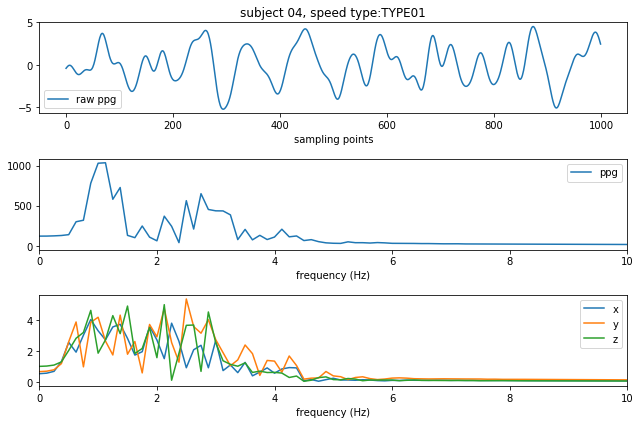

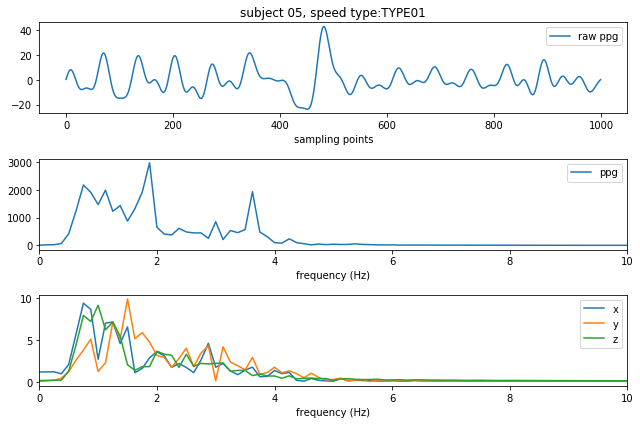

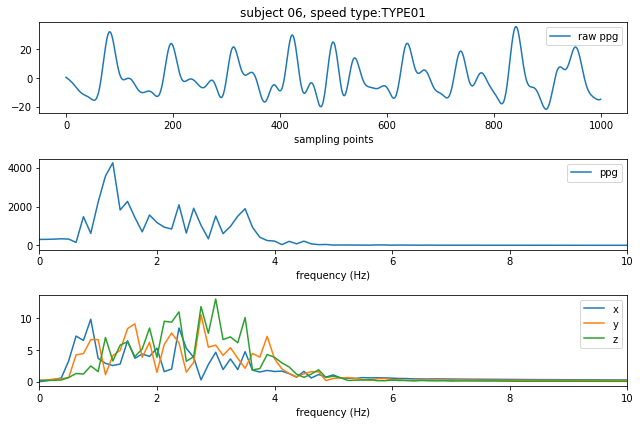

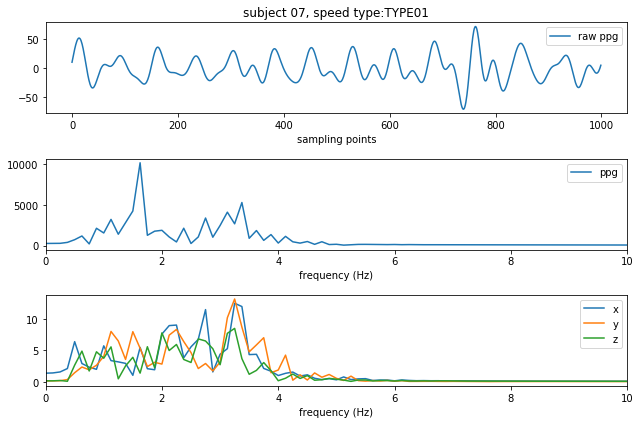

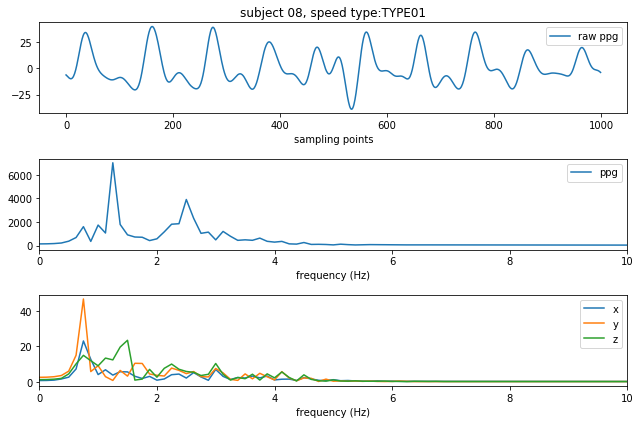

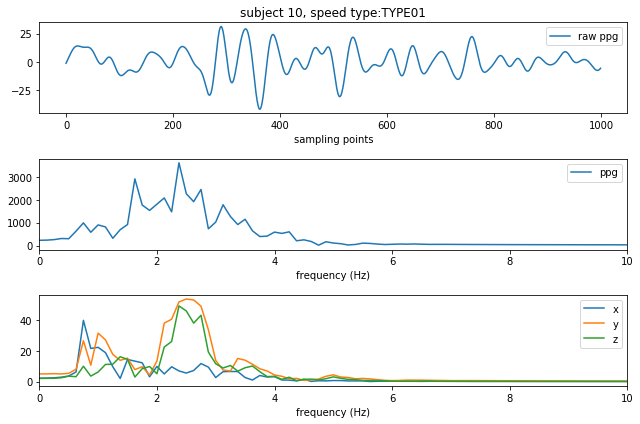

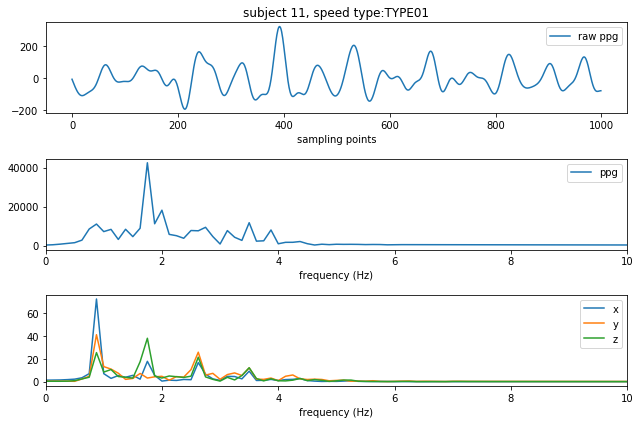

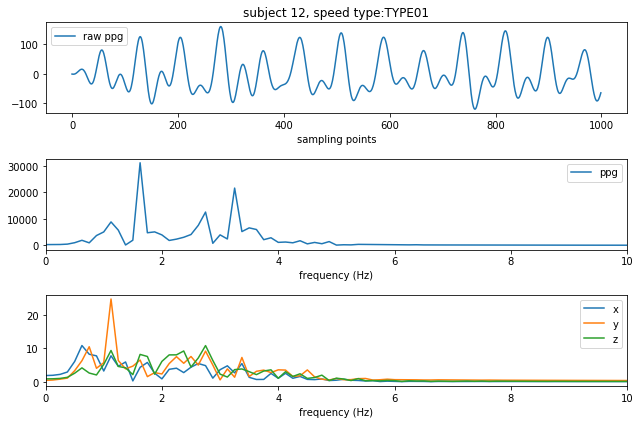

In [4]:
subjects = []
speed_types = []
data_fls, ref_fls = LoadTroikaDataset()
ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[2])
freq = np.fft.rfftfreq(window_length, 1/fs)

for i in range(len(data_fls)):
    subject = data_fls[i].split('_')[2]
    speed = data_fls[0].split('_')[3].split('.')[0]
    subjects.append(subject)
    speed_types.append(speed)

for d in range(len(data_fls)):
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[d])
    ppg = Bandpass_filter(ppg)
    accx = Bandpass_filter(accx)
    accy = Bandpass_filter(accy)
    accz = Bandpass_filter(accz)
    stft_ppg = []
    stft_accx = []
    stft_accy = []
    stft_accz = []
    for i in range(0, len(ppg) - window_length, window_shift):
        ppg_seg = ppg[i: i + window_length]
        accx_seg = accx[i: i + window_length]
        accy_seg = accy[i: i + window_length]
        accz_seg = accz[i: i + window_length]

        _, fft_ppg = Fourier_Transform(ppg_seg)
        _, fft_accx = Fourier_Transform(accx_seg)
        _, fft_accy = Fourier_Transform(accy_seg)
        _, fft_accz = Fourier_Transform(accz_seg)
        stft_ppg.append(fft_ppg)
        stft_accx.append(fft_accx)
        stft_accy.append(fft_accy)
        stft_accz.append(fft_accz)
    
    plt.figure(figsize=(9,6))
    plt.subplot(3,1, 1)
    plt.plot(ppg[0:window_length], label='raw ppg')
    plt.xlabel('sampling points')
    plt.title('subject {}, speed type:{}'.format(subjects[d], speed_types[d]))
    plt.legend()
    plt.subplot(3,1, 2)
    plt.plot(freq, stft_ppg[1], label = 'ppg')
    plt.xlabel('frequency (Hz)')
    plt.xlim(0,10)
    plt.legend()
    plt.subplot(3,1, 3)
    plt.plot(freq, stft_accx[1], label = 'x')
    plt.plot(freq, stft_accy[1], label = 'y')
    plt.plot(freq, stft_accz[1], label = 'z')
    plt.xlim(0,10)
    plt.xlabel('frequency (Hz)')
    plt.legend()
    plt.tight_layout()

-----
### Project Write-up

**Code Description**: run the Evaluate() function to execute the code

**Data Description**:   
The TROIKA dataset was used to train and test the algorithm. A single-channel PPG signal, a three-axis acceleration signal, and an ECG signal were collected simultaneoulsy from 12 male subjects with yellow skin and ages ranging from 18 to 35. The signals were recorded from wrist by two pulse oximeters with green LEDs (wavelength: 515nm) and a three-axis accelerometer. Both the pulse oximeter and the accelerometer were embedded in a wristband. During data recording, each subject ran on a treadmill with two types of changing speeds. The ground-truth of heart rate was calculated from the simultaneously recorded ECG signal. 

Limitations of the dataset:   
    Only include young male subjects with similar skin tone.
    Signal data was only collected in a well controlled environment. 
    Only one activity - running was recorded.  

Z. Zhang, Z. Pi, B. Liu, TROIKA: A general framework for heart rate monitoring using wrist-type photoplethysmographic signals during intensive physical exercise, IEEE Transactions on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015, DOI: 10.1109/TBME.2014.2359372  

**Algorithhm Description**:
The signal data first go through Bandpass_filter() to remove frequencies not between 40/60.0 and 240/60.0 Hz. Apply Fourier_Transform() on each signal segments to get the frequency domain within a window length of 8 seconds (1000 sampling points). Compare the dominant pgg signal frequencies and the accelerometer frequencies. Pick the strongest pgg frequencies that are not present in the accelerometer frequencies to exclude possible motion artifacts. Calculate estimation confidence. Compare the estimated heart rate (est_bpm) to ground truth and calcuate errors.

**Algorithm Performance**:
The algorithm performance was evaluated using the mean absolute error (MAE) at 90% availability.